In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#### The input is a 2D coordinate 
#### The target output is 1 if the point lies inside a circle of radius equal to 1
#### r=1 centered at the origin, and 0 otherwise.

In [2]:
# Generate synthetic data: points inside and outside a circle
np.random.seed(42)
num_points = 1000
X = np.random.uniform(-1.5, 1.5, (num_points, 2))  # Random points in a 2D space
y = (X[:, 0]**2 + X[:, 1]**2 <= 1).astype(float).reshape(-1, 1)  # 1 if inside the circle, 0 otherwise

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [3]:
X

tensor([[-0.3764,  1.3521],
        [ 0.6960,  0.2960],
        [-1.0319, -1.0320],
        ...,
        [ 0.7541,  0.4709],
        [ 1.3698, -1.2931],
        [-1.3288, -0.6534]])

In [8]:
X[:,0]

tensor([-0.3764,  0.6960, -1.0319, -1.3257,  0.3033, -1.4382,  0.9973, -0.9545,
        -0.5873, -0.2042,  0.3356, -0.6236, -0.1318, -0.9010,  0.2772,  0.3226,
        -1.3048,  1.3969, -0.5862,  0.5527, -1.1339, -1.3968, -0.7237, -0.5649,
         0.1401,  1.4088,  1.3185,  0.2937, -1.2345, -1.3643, -0.3340,  0.9862,
        -0.6572, -1.0772, -1.2763,  0.8167, -1.4834,  0.6206,  0.8138, -0.4246,
         1.0893, -0.5073, -0.5671,  0.6888,  1.1616, -1.1412,  0.7824,  0.8129,
         0.0682, -1.4237, -1.4057, -0.5569,  1.2227, -0.2689, -0.8136, -0.6307,
         1.2891,  0.4002,  0.9110,  1.1777,  0.9223, -0.5460, -0.8162,  0.9540,
        -1.4791, -0.2478, -1.1404,  1.3287,  0.0564, -0.4091,  1.3873, -0.0083,
        -0.6455,  0.3287, -1.3456,  1.2248, -1.0653,  1.4570,  0.5164, -0.7871,
        -0.3967,  0.4006, -1.2291, -0.5377, -1.3777,  0.5327,  0.0363,  0.4355,
         0.5728,  1.3102, -0.4768,  1.2741, -0.7262,  0.9517,  0.0890, -1.2207,
         1.2013, -0.4829,  0.6779,  1.16

In [5]:
# Add non-linear features (x1^2 + x2^2)
X_transformed = torch.cat([X, (X[:, 0]**2 + X[:, 1]**2).unsqueeze(1)], dim=1)

In [6]:
X_transformed

tensor([[-0.3764,  1.3521,  1.9700],
        [ 0.6960,  0.2960,  0.5720],
        [-1.0319, -1.0320,  2.1300],
        ...,
        [ 0.7541,  0.4709,  0.7904],
        [ 1.3698, -1.2931,  3.5486],
        [-1.3288, -0.6534,  2.1928]])

In [9]:
# Define the model
class SimplePerceptronWithFeatures(nn.Module):
    def __init__(self):
        super(SimplePerceptronWithFeatures, self).__init__()
        self.fc = nn.Linear(3, 1)  # 3 input features (x1, x2, x1^2 + x2^2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = SimplePerceptronWithFeatures()

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_transformed)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.1562
Epoch [200/1000], Loss: 0.1017
Epoch [300/1000], Loss: 0.0797
Epoch [400/1000], Loss: 0.0672
Epoch [500/1000], Loss: 0.0589
Epoch [600/1000], Loss: 0.0529
Epoch [700/1000], Loss: 0.0483
Epoch [800/1000], Loss: 0.0446
Epoch [900/1000], Loss: 0.0416
Epoch [1000/1000], Loss: 0.0390


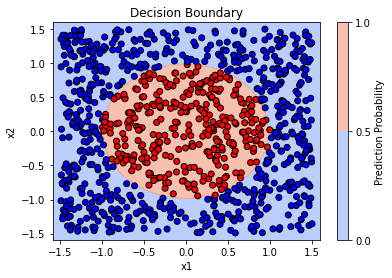

In [10]:
def plot_decision_boundary_with_features(model, X, y):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Add the non-linear feature (x1^2 + x2^2)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_with_feature = np.c_[grid, (grid[:, 0]**2 + grid[:, 1]**2)]  # Add x1^2 + x2^2

    # Convert to PyTorch tensor
    grid_tensor = torch.tensor(grid_with_feature, dtype=torch.float32)

    # Predict on the grid
    with torch.no_grad():
        preds = model(grid_tensor).reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.6, cmap="coolwarm")
    plt.colorbar(label="Prediction Probability")

    # Plot the input data points
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap="bwr", edgecolor="k")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.show()

# Call the function with transformed features
plot_decision_boundary_with_features(model, X.numpy(), y.numpy())